In [2]:
import numpy as np
import matplotlib.pyplot as plt

#LU decomposition subroutine
def getL(LU):
    dim = LU.shape[0]
    L = LU.copy()
    for i in range(dim):
            L[i, i] = 1
            L[i, i+1:] = 0
    return L

def getU(LU):
    dim = LU.shape[0]
    U = LU.copy()
    for i in range(1, dim):
        U[i, :i] = 0
    return U

def getLU(a, pres):
    dim = a.shape[0]
    a = a.copy()
    detSight = 1
    P = np.matrix(np.zeros(shape=(dim, dim)))
    Q = np.matrix(np.zeros(shape=(dim, dim)))
    np.fill_diagonal(P, 1)
    np.fill_diagonal(Q, 1)
    for i in range(dim - 1):
        (choseRow, choseCol) = np.unravel_index(np.argmax(np.abs(a[i:, i:])), a[i:, i:].shape)
        choseRow += i
        choseCol += i
        if choseRow != i:
            detSight *= -1
            a[[choseRow, i]] = a[[i, choseRow]]
            P[:, [choseRow, i]] = P[:, [i, choseRow]]
        if choseCol != i:
            detSight *= -1
            a[:, [choseCol, i]] = a[:, [i, choseCol]]
            Q[[choseCol, i]] = Q[[i, choseCol]]
        if np.abs(a[i, i]) < pres:
            return P, getL(a), getU(a), Q, detSight
        for j in range(i + 1, dim):
            coef = a[j, i] / a[i, i]
            a[j, i:] = a[j, i:] - a[i, i:]*coef
            a[j, i] = coef
    return P, getL(a), getU(a), Q, detSight

#solving
def directSub(L, B, P):
    dim = P.shape[0]
    B = P.transpose()*B
    Y = np.matrix(np.zeros(shape=(dim, 1)))
    for i in range(dim):
        summ = 0
        for j in range(i):
            summ += L[i, j]*Y[j, 0]
        Y[i, 0] = B[i, 0] - summ
    return Y

def inverceSub(U, Y, P, Q):
    dim = P.shape[0]
    X = np.matrix(np.zeros(shape=(dim, 1)))
    for i in range(dim):
        summ = 0
        for j in range(i):
            summ += U[dim - 1 - i, dim - 1 - j] * X[dim - 1 - j, 0]
        X[dim - 1 - i, 0] = (Y[dim - 1 - i, 0] - summ) / U[dim - 1 - i, dim - 1 - i]
    return (X.transpose()*Q).transpose()

def solve(a, b, pres):
    P, L, U, Q, Det = getLU(a, pres)
    Y = directSub(L, b, P)
    X = inverceSub(U, Y, P, Q)
    return X

functions = [
    lambda x: x - np.sin(4*x) - 0.25,
    lambda x: x**3 - np.exp(x),
    lambda x: np.log10(x+2) + 7/(2*x-6),
]

derivatives = [
    lambda x: 1 - 4*np.cos(4*x),
    lambda x: 3*x**2 - np.exp(x),
    lambda x: 1/(x+2) - 7/(2*x-6)**2
]

def get_values(x, func):
    y = []
    for x_ in x:
        y.append(func(x_))
    return y

def get_equal_range(a, b, n):
    range_ = []
    adder = (b - a) / (n - 1)
    for i in range(n):
        range_.append(a + adder * i)
    return range_

def get_optimal_range(a, b, n):
    range_ = []
    for i in range(n):
        range_.append(((b - a) * np.cos((2 * i + 1) * np.pi / (2 * n)) + (b + a)) / 2)
    return range_[::-1]

def find_indexes(arr, x):
    a = -1
    b = -1

    for i in range(len(arr)):
        if arr[i] <= x:
            a = i
        elif arr[i] > x:
            b = i
            break

    if a != -1 and b != -1:
        return a, b
    else:
        return None

class Spline1:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def calculate(self, x):
        if x in self.x:
            return self.y[self.x.index(x)]
        else:
            i_, i__ = find_indexes(self.x, x)
            return self.y[i_] + (self.y[i__] - self.y[i_])*(x - self.x[i_])/(self.x[i__] - self.x[i_])

    def calculate_range(self, x):
        y = []
        for x_ in x:
            y.append(self.calculate(x_))
        return y

class LocalSpline3:
    def __init__(self, x, y, dy):
        self.x = x
        self.y = y
        self.dy = dy

    def calculate(self, x):
        if x in self.x:
            return self.y[self.x.index(x)]
        else:
            i_, i__ = find_indexes(self.x, x)
            x_ = self.x[i_]
            x__ = self.x[i__]
            y_ = self.y[i_]
            y__ = self.y[i__]
            dy_ = self.dy[i_]
            dy__ = self.dy[i__]
            h = x__ - x_
            return (y_*(2*(x - x_) + h)*(x__ - x)**2)/(h**3) + (y__*(2*(x__ - x) + h)*(x - x_)**2)/(h**3) + (dy_*(x - x_)*(x__ - x)**2)/(h**2) + (dy__*(x - x__)*(x - x_)**2)/(h**2)

    def calculate_range(self, x):
        y = []
        for x_ in x:
            y.append(self.calculate(x_))
        return y

class GlobalSpline3:
    def __init__(self, x, y, mode='natural', dy_a=0, dy_b=0):
        self.x = x
        self.y = y
        self.mode = mode
        n = len(y)
        a = (np.eye(n, n, 1) + np.eye(n, n, -1) + 4*np.eye(n, n))
        a[0] = np.zeros(n)
        a[n - 1] = np.zeros(n)
        if mode == 'natural':
            h = x[1] - x[0]
            a[0][0], a[0][1], a[-1][-1], a[-1][-2] = 1, 0.5, 1, 0.5
            b = np.array(y)
            b = np.append(np.insert((b[2:] - b[:-2])*(3/h), 0, (y[1] - y[0])*(3/(2*h))), (y[-1] - y[-2])*(3/(2*h)))
            b = np.matrix(b).transpose()
        else:
            h = x[1] - x[0]
            a[0][0], a[-1][-1] = 1, 1
            b = np.array(y)
            b = np.append(np.insert((b[2:] - b[:-2])*(3/h), 0, dy_a), dy_b)
            b = np.matrix(b).transpose()
        self.dy = np.array(solve(a, b, 10**-12)).flatten()

    def calculate(self, x):
        if x in self.x:
            return self.y[self.x.index(x)]
        else:
            i_, i__ = find_indexes(self.x, x)
            x_ = self.x[i_]
            x__ = self.x[i__]
            y_ = self.y[i_]
            y__ = self.y[i__]
            dy_ = self.dy[i_]
            dy__ = self.dy[i__]
            h = x__ - x_
            return (y_*(2*(x - x_) + h)*(x__ - x)**2)/(h**3) + (y__*(2*(x__ - x) + h)*(x - x_)**2)/(h**3) + (dy_*(x - x_)*(x__ - x)**2)/(h**2) + (dy__*(x - x__)*(x - x_)**2)/(h**2)

    def calculate_range(self, x):
        y = []
        for x_ in x:
            y.append(self.calculate(x_))
        return y

In [8]:
def test(func, func_der, a, b, start_n, end_n, plot_n):
    for n in range(start_n, end_n+1):
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))
        plot_range = get_equal_range(a, b, plot_n)
        plot_values = get_values(plot_range, func)
        axs[0].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[1].plot(plot_range, plot_values, linewidth=2.0, color='g')
        axs[2].plot(plot_range, plot_values, linewidth=2.0, color='g')

        eq_range = get_equal_range(a, b, n)
        eq_values = get_values(eq_range, func)
        eq_pol = Spline1(eq_range, eq_values)
        eq_spline1_values = eq_pol.calculate_range(plot_range)
        axs[0].plot(plot_range, eq_spline1_values, linewidth=2.0, color='r')
        axs[0].set_title(f'S1, pnt: {n}, err: {np.around(np.linalg.norm(np.matrix(plot_values) - np.matrix(eq_spline1_values)), 2)}')
        axs[0].grid(True)

        eq_range = get_equal_range(a, b, n)
        eq_values = get_values(eq_range, func)
        eq_der_values = get_values(eq_range, func_der)
        eq_pol = LocalSpline3(eq_range, eq_values, eq_der_values)
        eq_spline1_values = eq_pol.calculate_range(plot_range)
        axs[1].plot(plot_range, eq_spline1_values, linewidth=2.0, color='r')
        axs[1].set_title(f'S31, pnt: {n}, err: {np.around(np.linalg.norm(np.matrix(plot_values) - np.matrix(eq_spline1_values)), 2)}')
        axs[1].grid(True)

        eq_range = get_equal_range(a, b, n)
        eq_values = get_values(eq_range, func)
        eq_pol = GlobalSpline3(eq_range, eq_values)
        eq_spline1_values = eq_pol.calculate_range(plot_range)
        axs[2].plot(plot_range, eq_spline1_values, linewidth=2.0, color='r')
        axs[2].set_title(f'S32, pnt: {n}, err: {np.around(np.linalg.norm(np.matrix(plot_values) - np.matrix(eq_spline1_values)), 2)}')
        axs[2].grid(True)

Test:


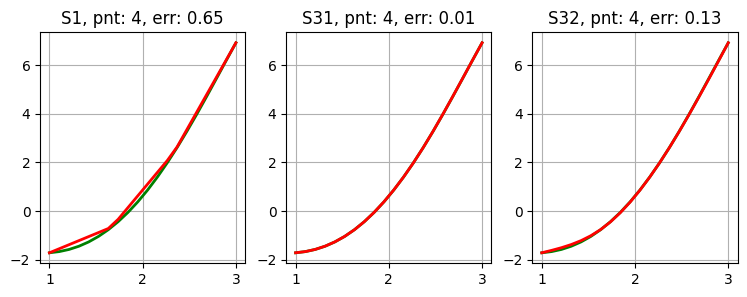

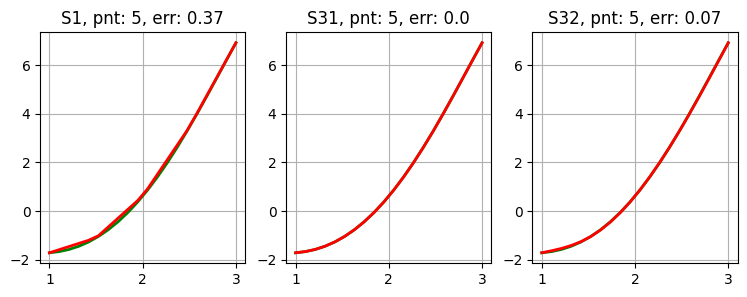

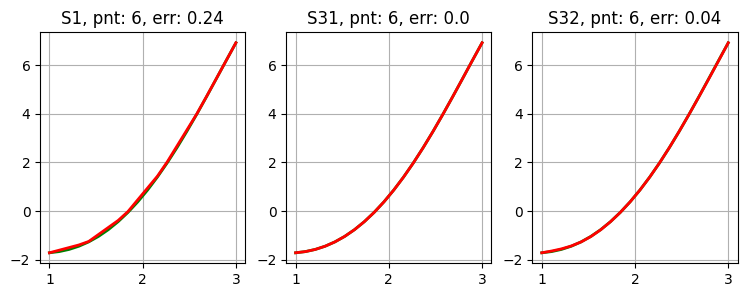

In [9]:
test_func = functions[1]
test_der = derivatives[1]
test_a = 1
test_b = 3
test_start_n = 4
test_end_n = 6
test_plot_n = 20
print('Test:')
test(test_func, test_der, test_a, test_b, test_start_n, test_end_n, test_plot_n)